# Decision Tree Classifier & Regressor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

import shap

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Data.csv', sep = ',')
data.head()

,Sector,CEO_Gender,Size,Security_Invest,Security_Breach_Att,Succ_Sec_Breaches,Sec_Rating,CEO_Sec_Exp,LOT_in_Business,Stock_Market
0,Banking,Female,Small,17,11,2,Medium,High,13,No
1,Banking,Male,Small,18,12,4,High,Low,9,No
2,Banking,Male,Small,17,12,4,High,Medium,22,No
3,Banking,Male,Small,24,13,1,High,Medium,3,Yes
4,Banking,Male,Small,32,14,3,High,Medium,4,Yes


## DecisionTreeRegressor

### 1. Prepare and Encode dataset

In [3]:
X = data.drop(['Succ_Sec_Breaches'], axis = 1)
y = data['Succ_Sec_Breaches']

In [4]:
nominal_variable = ['Sector', 'Stock_Market', 'CEO_Gender']
ordinal_variable = ['Size', 'Sec_Rating', 'CEO_Sec_Exp']
numeric_variable = ['Security_Breach_Att', 'Security_Invest', 'LOT_in_Business']

ordinal_encoder = OrdinalEncoder()
label_encoder = OneHotEncoder(handle_unknown = 'ignore')

preprocessor = ColumnTransformer([
    ('ordinal', ordinal_encoder, ordinal_variable),
    ('nominal', label_encoder, nominal_variable),
    ('numeric', 'passthrough', numeric_variable)
])

**code line: ('numeric', 'passthrough', numeric_variable)**

This line inthe ColumnTransformer tell it to **apply no transformation** for the numeric features of the data. Tree-based models, like Deccision Trees do **not requierr feature scaling**. Because trees split on feature thresholds, not distances or magnitudes. Scaling will not change their behavoir.

RobustScaler, StandardScaler, etc shall be used for the models sensitive to feature magnitude: Linear Regression, KNN, SVM, Neural Networks. But it is not necessary for Decision Tree, Random Forest, XGBoost, CatBoost, LightGBM.

### 2. Train the model

In [5]:
def print_metrics(y_train, y_train_pred, y_test, y_test_pred):
    
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_pred)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_pred)))
    print('Train RMSE: {:.3f}'.format(metrics.root_mean_squared_error(y_train, y_train_pred)))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_pred)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_pred)))
    print('Test RMSE: {:.3f}'.format(metrics.root_mean_squared_error(y_test, y_test_pred)))

In [6]:
# Initial Model run

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state = 42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 1.000
Train MAE: 0.000
Train RMSE: 0.000


Test R^2: 0.666
Test MAE: 5.250
Test RMSE: 10.618


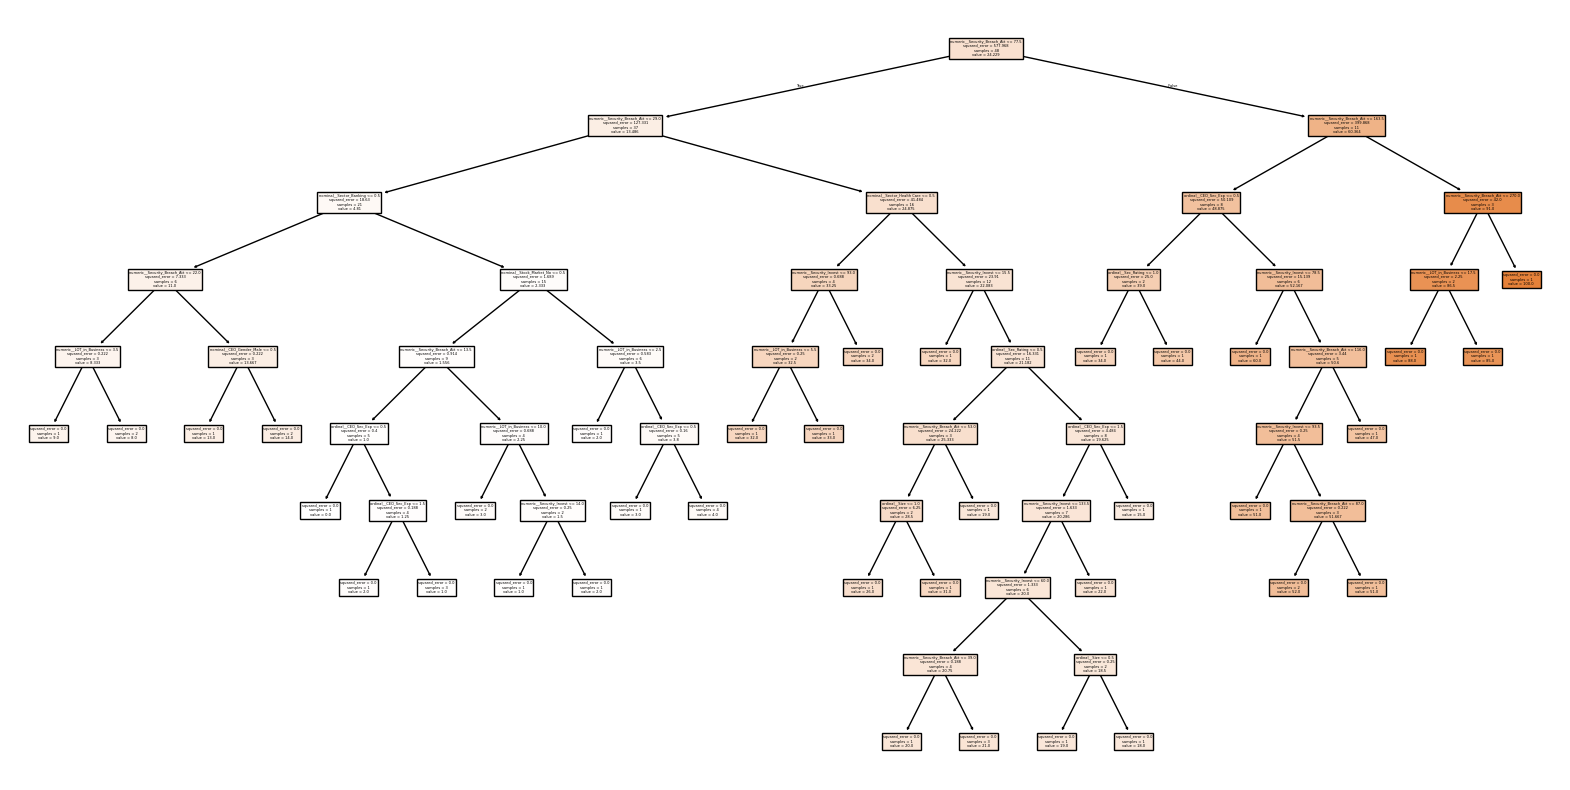

In [7]:
# Visualization

from sklearn.tree import plot_tree

model = pipeline.named_steps['regressor']
plt.figure(figsize = (20, 10))
plot_tree(model, filled = True,
          feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out())
plt.show();

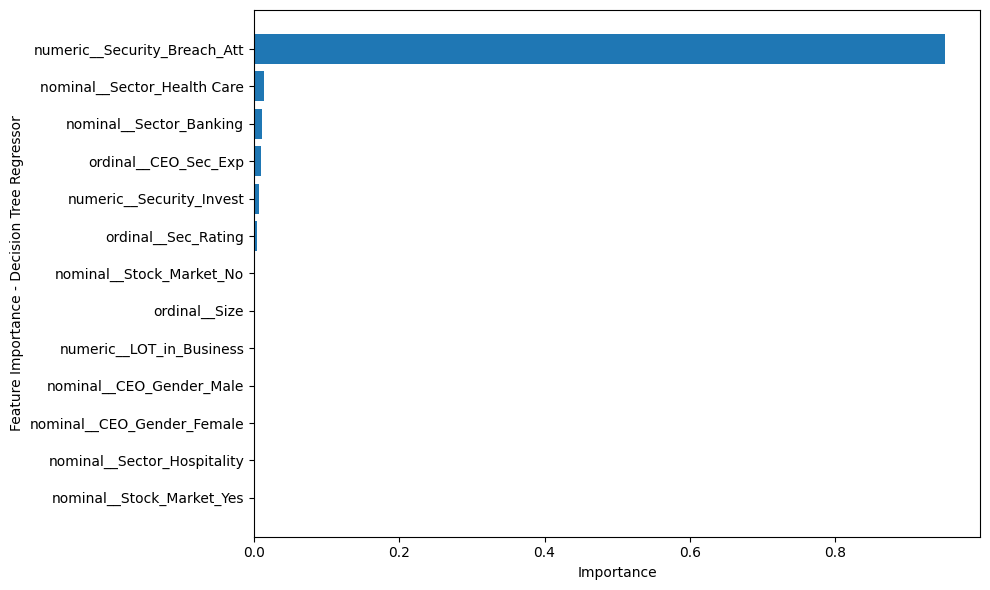

In [8]:
# Feature Importance

tree_model = pipeline.named_steps['regressor']
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = tree_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature' : feature_names,
    'Importance' : importances
})

feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature Importance - Decision Tree Regressor')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show();

**SHAP (Shapley Additive exPlanations)** is the powerful Python module used for explaining the **predictions of any machine learning model** by computing the **contribution of each feature** to the prediction - both globally and locally.

SHAP uses the **Shapley values** from cooperative game theory to assign each feature a value indicating how much it contributed to the difference between:

- The **model's prediction** for an instance, and
- The **average prediction (base value)** across all data points

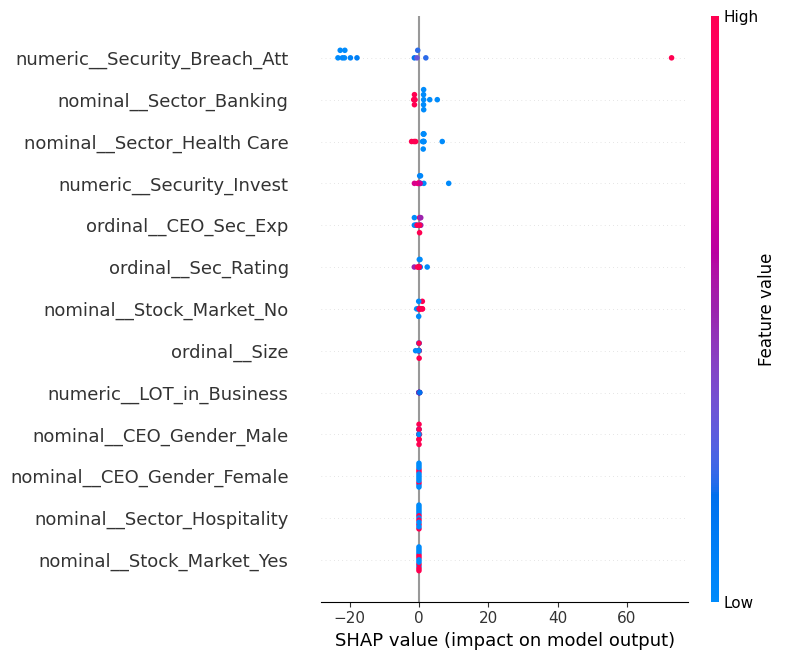

In [9]:
# Shap (SHapley Additive exPlanations)

tree_model = pipeline.named_steps['regressor']

X_preprocessed = pipeline.named_steps['preprocessor'].transform(X_test)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_preprocessed)

shap.summary_plot(shap_values, features = X_preprocessed, feature_names = feature_names)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], feature_names = feature_names)

### Conclusion:

Train and Test Metrics show that there is perfect prediction on training data - too perfect and significant drop in performance on unseen data. In other words the model (Decision Tree Regressor) learn the training data perfectly - the possible reason: few samples - 60 entries is too small. There are the following possible options to try to improve the results of the Decision Tree Regressor:

- Prune the Tree: control depth and splits. This should prevent the tree from memorizing the training data and force it to learn general patterns.
  
- Cross-Validation. This gives a better estimate of true performance

In [10]:
# Second Model Run

regressor = DecisionTreeRegressor(max_depth = 4,
                                 min_samples_leaf = 5,
                                 min_samples_split = 10,
                                 random_state = 42)

pipeline_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

pipeline_2.fit(X_train, y_train)

y_train_pred_2 = pipeline_2.predict(X_train)
y_test_pred_2 = pipeline_2.predict(X_test)

print_metrics(y_train, y_train_pred_2, y_test, y_test_pred_2)

Train R^2: 0.907
Train MAE: 4.410
Train RMSE: 7.336


Test R^2: 0.929
Test MAE: 3.513
Test RMSE: 4.906


In [11]:
# Cross Validation Scores

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(pipeline_2, X, y, cv = 5, scoring = 'r2')

print('Cross-Validation R2 Scores: ', cv_scores)
print('Average cross - validated R2: {:.3f}'.format(cv_scores.mean()))

Cross-Validation R2 Scores:  [0.8757753  0.89590823 0.64810843 0.8039787  0.73071811]
Average cross - validated R2: 0.791


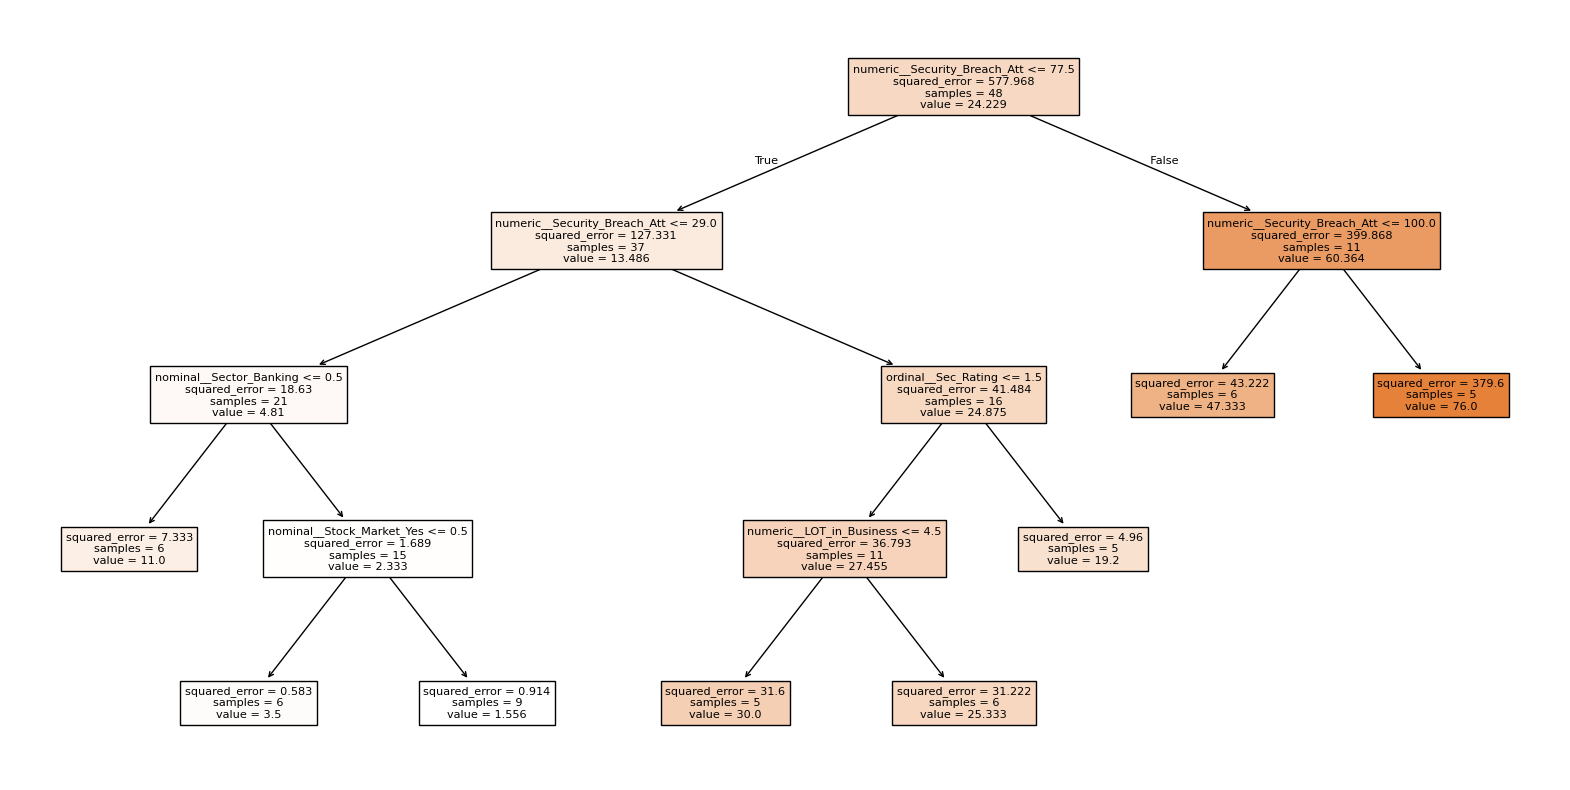

In [12]:
# Visualization

model_2 = pipeline_2.named_steps['regressor']
plt.figure(figsize = (20, 10))
plot_tree(model_2, filled = True,
          feature_names = pipeline_2.named_steps['preprocessor'].get_feature_names_out())
plt.show();

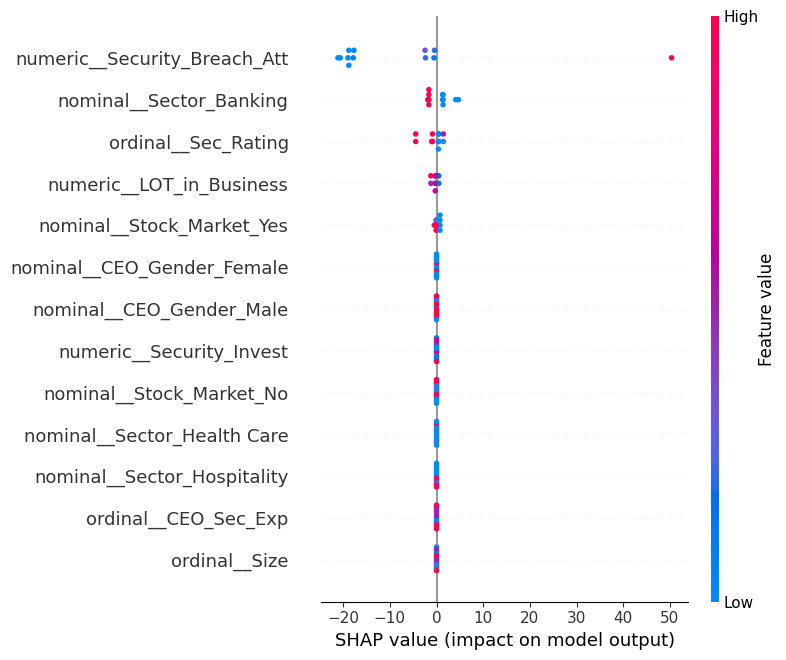

In [13]:
# Shap (SHapley Additive exPlanations)

tree_model_2 = pipeline_2.named_steps['regressor']

X_preprocessed_2 = pipeline_2.named_steps['preprocessor'].transform(X_test)
feature_names_2 = pipeline_2.named_steps['preprocessor'].get_feature_names_out()

explainer_2 = shap.TreeExplainer(tree_model_2)
shap_values_2 = explainer_2.shap_values(X_preprocessed_2)

shap.summary_plot(shap_values_2, features = X_preprocessed_2, feature_names = feature_names_2)
shap.initjs()
shap.force_plot(explainer_2.expected_value, shap_values_2[0], feature_names = feature_names_2)

### Conclusion:

1. Top Features in both runs of the model:

|**Feature Name**|**Role and Insight**|
|--|--|
|Number Security Breach Attemps|Most impactful in both models - intuitively important and consistent|
|Business Sector|Continues to have high positive impact; secure or high-risk environment?|

2. Changes in Feature Importance

|**Feature**|**Initial Model**|**Improved Model**|
|--|--|--|
|CEO Security Experience|High influence (positive)|Dropped to low importance|
|Security Rating|Moderate Importance|Became more prominent|
|Investments|Previously relevant|Became more important|
|Business is on the Stock Market|Moved up as more informative|Strong influence on decreasing prediction|
|Business Sector (Health)|Had strong negative impact|Less important in pruned model|

The model with pruning reduced overfitting and placed more weight on the features that generalize better (Security Rating and Business being on the Stock Market). SHAP plots now show tighter clustering, indicating more stable feature effects.

3. Model Performance

|**Metric**|**Initial Model**|**Improved Model**|**Result**|
|--|--|--|--|
|Train R2|1.000|0.907|Reduced overfitting|
|Test R2|0.666|0.929|Major improvement|
|Train RMSE|0.000|7.336|Realistic now|
|Test RMSE|10.618|4.906|Much better|
|Test MAE|5.250|3.513|Reduced error|

The original model was memorizing the training data. The pruned model is now learning patterns that generalize well, as shown by slightly lower training R2 and much higher test R2. This is the classic case of moving from overfitting to generalization.

4. Cross-Validation R2: 0.791

Cross-validation confirms that model is stable across multiple folds: 

- A cross-validation of 0.791 indicates reliable performance and minimal data leakage;
- It gives confidence that the results are not just due to a lucky test split.

#### The next step is to fine and tune hyperparameters using RandomizedCV

In [14]:
from sklearn.model_selection import RandomizedSearchCV

rs_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state = 42))
])

param_distributions = {
    'regressor__max_depth' : [3, 5, 10, 15, 20, None],
    'regressor__min_samples_split' : [2, 5, 10, 15],
    'regressor__min_samples_leaf' : [1, 2, 4, 6],
    'regressor__max_features' : ['auto', 'sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    estimator = rs_pipeline,
    param_distributions = param_distributions,
    n_iter = 25,
    scoring = 'r2',
    cv = 5,
    verbose = 1,
    n_jobs = -1,
    random_state = 42
)

random_search.fit(X, y)

print('Best Parameters:', random_search.best_params_)
print('Best Cross-Validated R2 Score: {:.3f}'.format(random_search.best_score_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__max_features': None, 'regressor__max_depth': 15}
Best Cross-Validated R2 Score: 0.780


### Conclusion:

|**Aspect**|**Comment**|
|--|--|
|Model Generalization|With R2 = 0.780 on cross-validation, the model generalizes quite well - a big improvement over the untuned tree (which showed overfitting)|
|Tree Pruning|max_depth = 5, min_samples_split = 10, and min_saples_leaf = 4 help restrict the tree from over-complex branching - which combats overfitting|
|max_features = None|The tree considered all features at each split - this is okay for small datasets but could be tuned further of needed.|
|Model Stability|5-fold cross-validation confirms the model is stable and not overly dependent on specific splits.|

The tuned model is significantly more robust than the first overfitted version. A cross-validated R2 score of 0.780 is comparable to or slightly lower than the pruned tree with manual hyperparameters (0.791) - this indicates consistent improvement. Interpretability and performance was optimized using a simple, well-pruned tree.

## DecisionTreeClassifier

### 1. Review and Encode dataset

In [15]:
data['Sec_Rating'].value_counts(normalize = True)

Sec_Rating
Medium    0.366667
High      0.350000
Low       0.283333
Name: proportion, dtype: float64

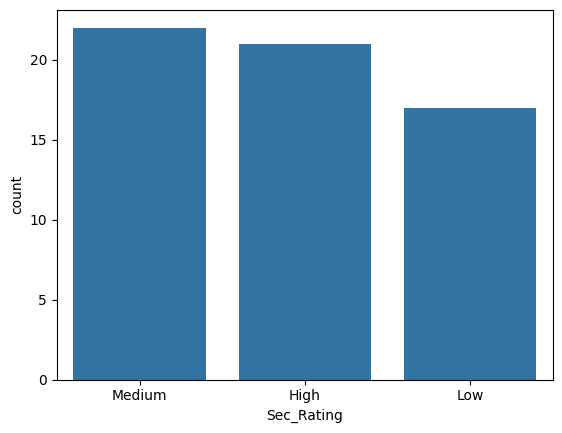

In [16]:
sns.countplot(data, x = 'Sec_Rating');

### Conclusion:

While this is not a severe imbalance, it is still enough that a random train-test split might accidentally underrepresent one class, especially on such a small dataset (60 entries). 

Stratified splitting ensures that each split (train/test) retains the same proportion of class labels as the original dataset.

In [17]:
# Define features and target 

X = data.drop('Sec_Rating', axis = 1)
y = data['Sec_Rating']

# Define features by type

ordinal_variable = ['Size', 'CEO_Sec_Exp']
nominal_variable = ['Sector', 'Stock_Market', 'CEO_Gender']
numeric_variable = ['Security_Invest', 'Security_Breach_Att', 'Succ_Sec_Breaches', 'LOT_in_Business']

# Define ordinal categories (assumed order based on context)

ordinal_categories = [
    ['Small', 'Medium', 'Large'],
    ['Low', 'Medium', 'High']
]

# Target encoding
y = OrdinalEncoder(categories = [['Low', 'Medium', 'High']]).fit_transform(y.values.reshape(-1, 1)).ravel()

# Preprocessing pipeline

preprocessor = ColumnTransformer(transformers = [
    ('ordinal', OrdinalEncoder(categories = ordinal_categories), ordinal_variable),
    ('nominal', OneHotEncoder(), nominal_variable),
    ('numeric', 'passthrough', numeric_variable)
])

When using OrdinalEncoder, we need to **explicitly define the correct order of categories** - otherwise, the encoder will assign an arbitrary order (for example, alphabetical) which may be **incorrect for ordinal data**.

**Code line**: 

- **ordinal_categories = [['Low', 'Medium', 'High']]**

- **OrdinalEncoder(categories = ordinal_categories)**

ensures:

- Low -> 0
- Medium -> 1
- High -> 2

the **true ordinal meaning**, so the model can learn correct relationships - Medium is between Low and High

### 2. Train the model

In [18]:
# Initial Run

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state = 42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

report_train = metrics.classification_report(y_train, y_train_pred, target_names = ['Low', 'Medium', 'High'])
report_test = metrics.classification_report(y_test, y_test_pred, target_names = ['Low', 'Medium', 'High'])

print('Train', report_train)
print('\n')
print('Test', report_test)

Train               precision    recall  f1-score   support

         Low       1.00      1.00      1.00        14
      Medium       1.00      1.00      1.00        17
        High       1.00      1.00      1.00        17

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



Test               precision    recall  f1-score   support

         Low       0.25      0.33      0.29         3
      Medium       0.75      0.60      0.67         5
        High       0.50      0.50      0.50         4

    accuracy                           0.50        12
   macro avg       0.50      0.48      0.48        12
weighted avg       0.54      0.50      0.52        12



### Conclusion:

Accuracy = 1.00 on train set - perfect scores across all classes - clasic sign of overfitting. Model memorized training data. Accuracy = 0.50 on test set - moderate performance. Recall for Low = 0.33, High = 0.50, so model is struggling to generalize.

**Reasons**:
- Small Dataset (60 samples only)
- Unresticted Decision Tree (max_depth, min_samples_leaf, etc)
- No regularization or pruning

**Ways forward**

- Fine and tune hyperparameters with RandomizedSearchCV algorithms
- Cross-validation
- Analyze Feature Importance

In [19]:
# Second Model run

param_distributions = {
    'classifier__max_depth' : [2, 3, 4, 5, 6, 7, 8, None],
    'classifier__min_samples_split' : [2, 4, 6, 8, 10],
    'classifier__min_samples_leaf' : [1, 2, 4, 6],
    'classifier__max_features' : ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions = param_distributions,
    n_iter = 25,
    scoring = 'f1_macro',
    cv = 5,
    verbose = 0,
    n_jobs = -1,
    random_state = 42
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('Best parameters: \n', random_search.best_params_)
print('\n')
print('Train:', metrics.classification_report(y_train, y_train_pred, target_names = ['Low', 'Medium', 'High']))
print('Test:', metrics.classification_report(y_test, y_test_pred, target_names = ['Low', 'Medium', 'High']))
print('\n')
print('Best Cross-Validated F1 Score: {:.3f}'.format(random_search.best_score_))

Best parameters: 
 {'classifier__min_samples_split': 8, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': None}


Train:               precision    recall  f1-score   support

         Low       0.83      0.71      0.77        14
      Medium       0.67      0.82      0.74        17
        High       0.80      0.71      0.75        17

    accuracy                           0.75        48
   macro avg       0.77      0.75      0.75        48
weighted avg       0.76      0.75      0.75        48

Test:               precision    recall  f1-score   support

         Low       0.20      0.33      0.25         3
      Medium       0.33      0.40      0.36         5
        High       0.00      0.00      0.00         4

    accuracy                           0.25        12
   macro avg       0.18      0.24      0.20        12
weighted avg       0.19      0.25      0.21        12



Best Cross-Validated F1 Score: 0.472


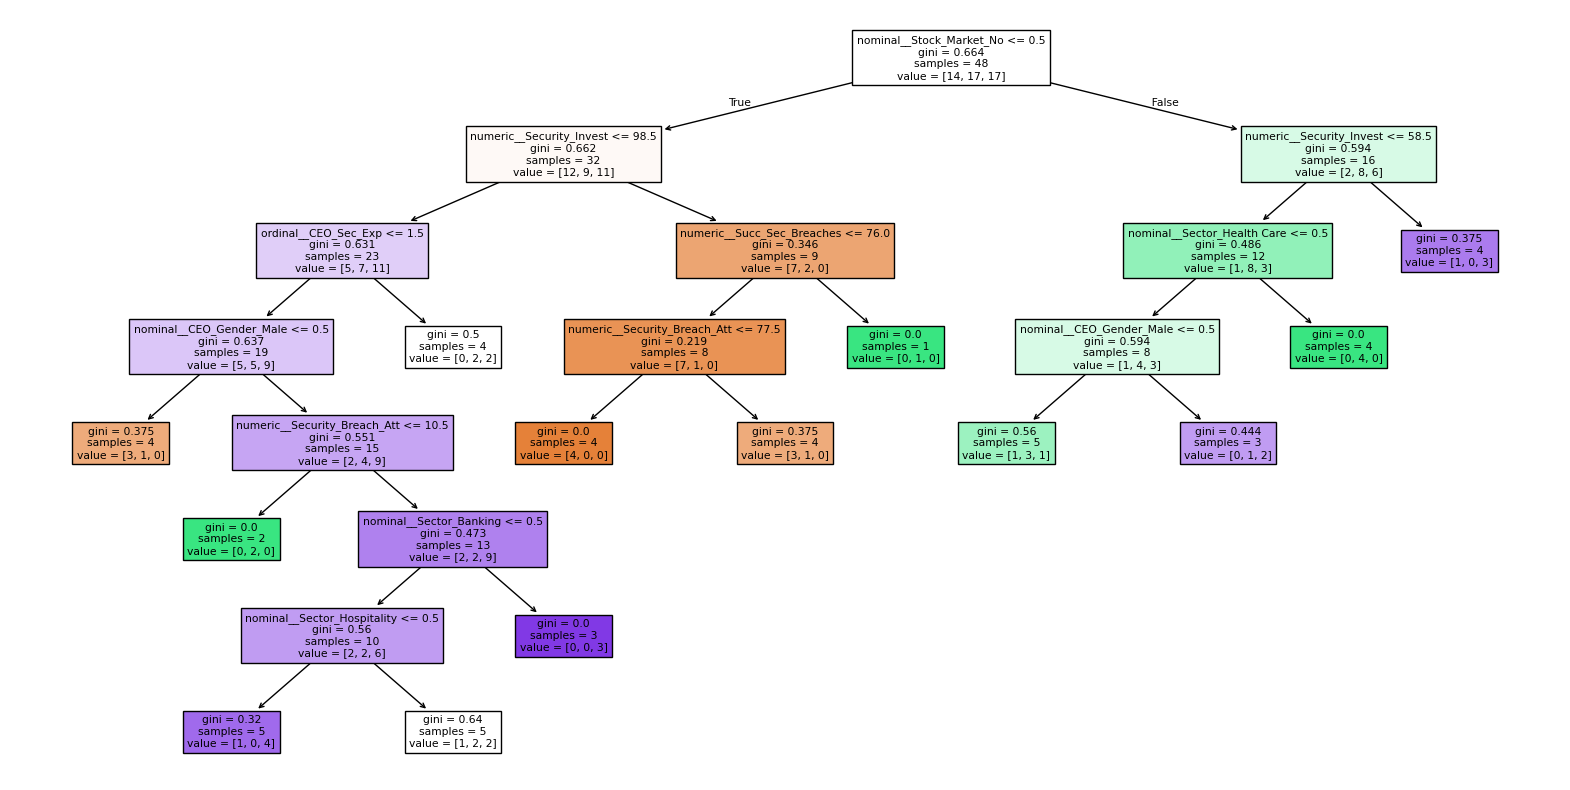

In [20]:
# Visualization

model = best_model.named_steps['classifier']
plt.figure(figsize = (20, 10))
plot_tree(model, filled = True,
          feature_names = best_model.named_steps['preprocessor'].get_feature_names_out())
plt.show();

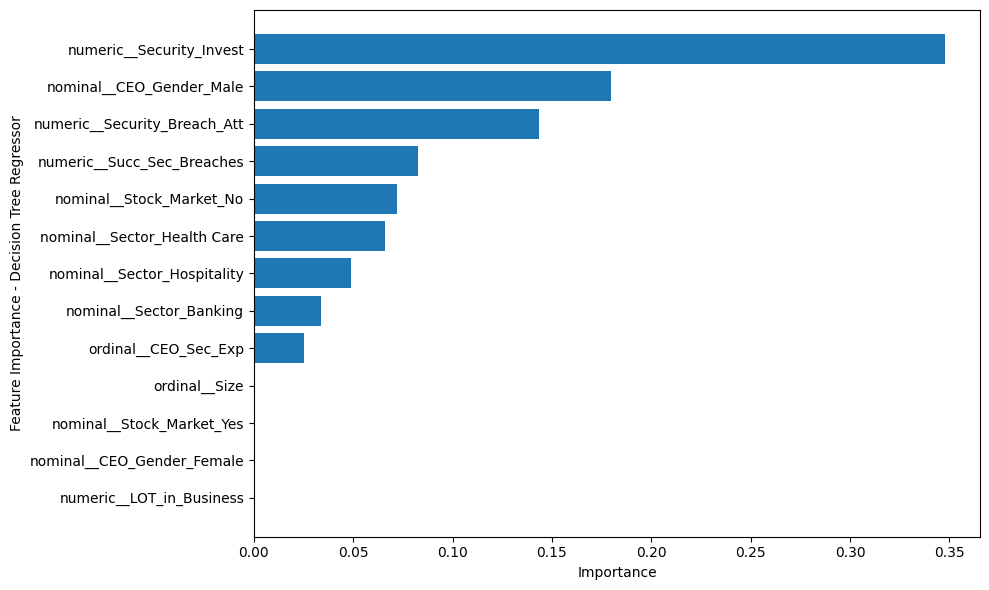

In [21]:
# Feature Importance

tree_model = best_model.named_steps['classifier']
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
importances = tree_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature' : feature_names,
    'Importance' : importances
})

feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature Importance - Decision Tree Regressor')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show();

### Conclusion:

Initial model overfits: perfect on training, only average on test. The pruined model reduced overfitting, but performance dropped due to limited generalization.

The decision tree diagram shows:
- the root split is on Stock_Market and Security_Invest, confirming their high predictive influence
- leaf nodes are quite pure, but this often means the tree overfits small patterns
- certain features like CEO_Sec_Exp and Security_Breach_Att appear multiple times - indicating they are locally important but not globally dominant.

